# Interpolación de banda limitada para el tipo de cambio del dólar
© 2018 [Juan M. Fonseca-Solís](https://cr.linkedin.com/in/juan-m-fonseca-solis)
- - - 
## Resumen

La interpolación de banda limitada es un método numérico que permite reconstruir señales continuas a partir de muestras tomadas de manera irregular, es decir, sin seguir una tasa de muestreo fija. Este es un problema interesante de resolver para cualquier investigador que se encuentre estudiando una señal construida con datos dispersos, pues le permite alcanzar una buena aproximación aún cuando los datos no cumplan las reglas de muestreo de Nyquist (un problema frecuente para los ingenierios de minado de datos). Para ejemplificar la utilidad del método se propone estudiar el comportamiento del tipo de cambio del dólar en Costa Rica desde el 2014, un tema que se a puesto de moda ya que el 4 de setiembre del 2018 la moneda subió al rango de 580 a 585 colones, afectando a gente que tenía deudas en esa moneda por el incremento en las tasas de interés. El Banco Central de Costa Rica (BCCR) provee un servicio web que permite obtener los datos de manera equidistante, pero se realiza un muestreo aleatorio sobre esa información para simular el caso de un investigador que solo cuente con anotaciones propias realizadas de manera irregular.

## Consumo del servicio web

Primero, es necesario cargar las librerías necesarias para consumir el servicio SOAP. Para ello, importamos la dependencias de [Zolera Soap Infraestructure](http://pywebsvcs.sourceforge.net/zsi.html) para python.

In [4]:
import xml.etree.ElementTree as ET  # librería para leer el xml
from ZSI.ServiceProxy import ServiceProxy  # libería para consumir el servicio SOAP

ModuleNotFoundError: No module named 'ZSI'

Luego, consumimos la operación "ObtenerIndicadoresEconomicosXML" del WSDL del BCCR que recibe cinco parámetros:
* **ID del indicador** (según [1] el ID es 317 para obtener el tipo de cambio de compra)
* **Fecha inicial** (dd/mm/yyy)
* **Fecha final** (dd/mm/yyy)
* **Nombre del usuario** (irrelevante pues no afecta la operación)
* **Char Y/N** (comunica si se desea obtener un reporte detallado con subindicadores)

El cuerpo del resultado es un XML que tiene la forma:

    <string><Datos_de_INGC011_CAT_INDICADORECONOMIC>
      <INGC011_CAT_INDICADORECONOMIC>
        <COD_INDICADORINTERNO>317</COD_INDICADORINTERNO>
        <DES_FECHA>2014-01-01T00:00:00-06:00</DES_FECHA>
        <NUM_VALOR>495.01000000</NUM_VALOR>
      </INGC011_CAT_INDICADORECONOMIC>
      (...)
    </Datos_de_INGC011_CAT_INDICADORECONOMIC></string>
    
Para consumir el servicio y obtener un arreglo de flotantes a partir del XML<sup>3</sup> usamos el siguiente código:

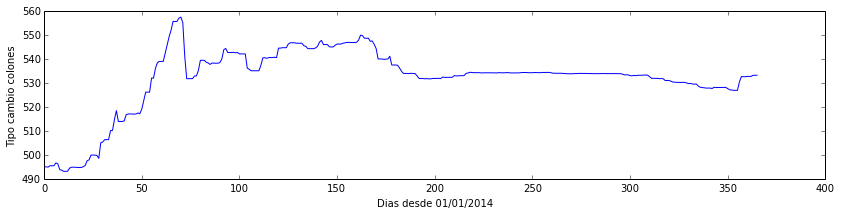

In [197]:
# creamos un proxy con los servicios del WSDL
URL_WSDL = ("http://indicadoreseconomicos.bccr.fi.cr/"+
"IndicadoresEconomicos/WebServices/wsIndicadoresEconomicos.asmx?WSDL")
servicio = ServiceProxy(URL_WSDL)

fechaInicio = '01/01/2014'
fechaFinal = '01/01/2015'

# encontramos el valor de compra del dólar durante todo el 2014
dicc = servicio.ObtenerIndicadoresEconomicosXML(
	tcIndicador='317',
	tcFechaInicio=fechaInicio,
	tcFechaFinal=fechaFinal,
	tcNombre = 'test',
	tnSubNiveles = 'N')

# sacamos el XML que viene encapsulado en el diccionario
xml = dicc['ObtenerIndicadoresEconomicosXMLResult']
raiz = ET.fromstring(xml)

# almacenamos los valores de cambio en un arreglo
z = []
for hijo in raiz:
	act = float(hijo[2].text)
	z.append(act)

# graficamos los valores obtenidos
N = len(z)
x = range(N)  # eje de las ordenadas
pylab.rcParams['figure.figsize'] = (14.0, 3.0) # dimensiones del gráfico
pylab.plot(x,z)
pylab.xlabel('Dias desde ' + fechaInicio)
pylab.ylabel('Tipo cambio colones')
pylab.show()

## Decimación aleatoria de la señal original

Para demostrar la utilidad de la interpolación BL es necesario crear versión decimada de la señal original. Para ello tomamos muestras, aleatoriamente, de los valores de tipo de cambio. 

En la figura de la izquierda podemos ver los puntos rojos que corresponden a las muestras tomadas, y en la figura de la derecha la interpolación más simple que consiste en unir los puntos con una línea recta. Obviamente ésta forma de interpolación no resulta la más adecuada porque no estima el valor de las curvas que hay entre los puntos.

In [1]:
import random
p = 0.75 # probabilidad de tomar una muestra

xm = []
zm = []
for dia in range(len(x)):
    if p<random.random():
        xm.append(x[dia])
        zm.append(z[dia])
    
# graficamos el resultado
pylab.rcParams['figure.figsize'] = (14.0, 5.0) # dimensiones del gráfico

subplot(1,2,1)
pylab.plot(x,z,'b-',xm,zm,'or') 
pylab.xlabel('Das desde ' + fechaInicio)
pylab.ylabel('Tipo cambio compra')

subplot(1,2,2)
pylab.plot(x,z,'b-',xm,zm,'r-')
pylab.xlabel('Dias desde ' + fechaInicio)
pylab.ylabel('Tipo cambio colones')
pylab.show()

NameError: name 'x' is not defined

## Interpolación de banda limitada

Ahora usamos interpolación de banda limitada para aproximar la señal original usando series de Fourier, es decir haciendo una suma de senoidales con una amplitud, frecuencia y desfase distintos.<sup>4</sup>

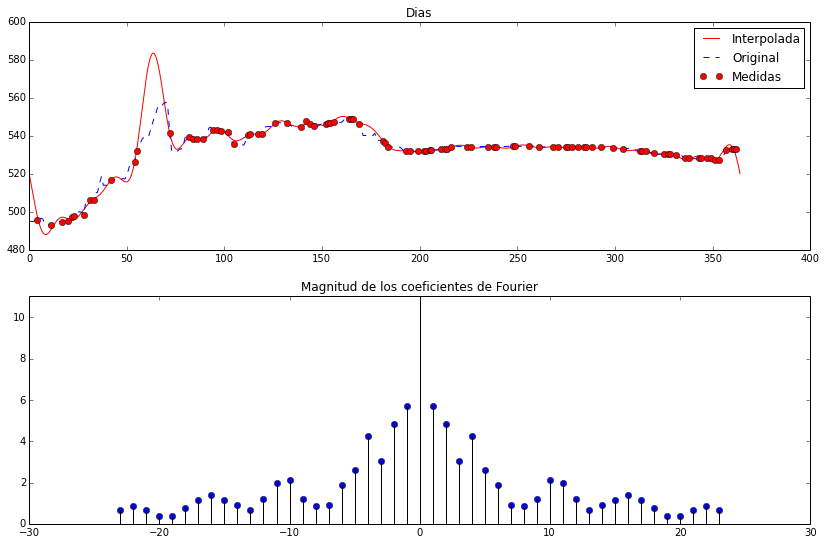

In [193]:
from numpy import *
from matplotlib.pylab import *
import random

def BL_interp_1D(x, z, T, order, grid_step=0.01, win=True):
    """
    Band-limited interpolation of 1D functions (código obtenido de P.Prandoni, M.Vetterli)
    """
    # Create Fourier order vector
    k = expand_dims(arange(-order, order+1), 0)
    
    # construct the Fourier matrix
    F = exp(2j*pi*x*k/(T[1]-T[0]))
    
    # Least-square projection (alternatively linalg.lstsq can be used)
    C = dot(dot(linalg.inv(dot(F.T,F)), F.T), z)
    
    # create new evenly spaced grid
    xg = expand_dims(arange(T[0], T[1], grid_step), 1)
    
    # window the Fourier coefficients if requested
    if (win):
        C *= expand_dims(hanning(2*order+1), 1)
    
    zg = dot(exp(2j*pi*xg*k/(T[1]-T[0])), C)
        
    return zg, xg, C, k

'''
Aplicamos la interpolación BL
'''
orden = 23 # número de coeficientes de la aproximación (empírico)
T = [0, 364]
xmp = expand_dims(array(xm),1)
zmp = expand_dims(array(zm),1)

# calculamos la interpolación BL
zp1, xp1, C1, k1 = BL_interp_1D(xmp, zmp, T, orden, win=False)

# graficamos el resultado
pylab.rcParams['figure.figsize'] = (14.0, 9.0) # dimensiones del gráfico
subplot(2,1,1)
plot(xp1, real(zp1), 'r-', x, z, 'b--', xm, zm, 'ro')
title('Dias')
legend(('Interpolada', 'Original','Medidas'))

subplot(2,1,2)
stem(k1.T, abs(C1), 'k')
ylim([0, mean(C1)])
title('Magnitud de los coeficientes de Fourier')

show()

Como podemos apreciar, es posible obtener una mejor aproximación (que usando interpolación lineal) con unos pocos coeficientes, es más si la señal es periódica el método BL puede funcionar incluso si el muestreo de hace de forma aleatoria. 

En contrapartida, si la señal es aperiódica y se pide realizar una aproximación entre dos puntos lejanos, el método BL podría agregar saltos donde no los hay. Sin embargo, es aceptable porque el método usa pocos coeficientes y porque para esos casos ya existe la interpolación spline.

## Cantidad de coeficientes

Como la gráfica de los coeficientes es par, solo necesitamos almacenar la mitad de los coeficientes, es decir que podemos calcular el porcentaje de compresión de la siguiente manera:

$$\text{nc}=\frac{dim(\text{zm})-0.5 \, \text{orden}}{dim(\text{zm})}$$

In [185]:
nc = (len(zm)-(orden*0.5))/len(zm)
print 'Muestras tomadas: ',len(zm)
print 'Cantidad de coeficientes: ', orden/2, ' (necesarios para reproducir la señal)'
print 'Compresión lograda: ', int(nc*100),'%'

Muestras tomadas:  95
Cantidad de coeficientes:  11  (necesarios para reproducir la señal)
Compresión lograda:  88 %


## Referencias:

1. Banco Central de Costa Rica. **Catálogo de indicadores económicos disponibles a consultar**. URL: http://www.bccr.fi.cr/indicadores_economicos_/ServicioWeb.html. Última vez consultado: 04/11/15

* Ecolé Polytechnique Federale de Lausanne. **Band-limited interpolation of radiation measurements in Fukushima**.

## Notas
1. Decimación quiere decir reducir la tasa de muestreo de la señal, es decir reducir la cantidad de puntos que contiene la misma
* Un excelente recurso de cómo usar los servicios del BCCR también puede encontrarse en [Tico](https://tecnitico.wordpress.com/2010/11/11/webservice-del-banco-central-de-costa-rica-y-ruby/)
* Para escribir este ipython notebook se usó la sintaxis [Markdown](https://help.github.com/articles/markdown-basics/) y un interpretador [XML](https://docs.python.org/2/library/xml.etree.elementtree.html). Aunque no fue usado, éste documento soporta $\LaTeX$
* Es importante destacar que el método BL no consiste solo en aplicar la transformada discreta de Fourier, sino también en reconstruir la señal a partir de los coeficientes obtenidos para los puntos que no forman parte del muestreo original

---
<a rel="license" href="http://creativecommons.org/licenses/by-nd/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="img/80x15_by-nd.png" /></a><br />Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nd/4.0/">licencia de Creative Commons Reconocimiento-SinObraDerivada 4.0 Internacional</a>.